In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim

import torchvision
import torchvision.transforms as T
import torchvision.ops as OPS

import matplotlib.pyplot as plt

In [ ]:
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
!unzip PennFudanPed

--2022-04-15 10:50:48--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  26.3MB/s    in 1.9s    

2022-04-15 10:50:50 (26.3 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]

Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: PennFudanPed/Annotation/FudanPed00002.txt  
  inflating: PennFudanPed/Annotation/FudanPed00003.txt  
  inflating: PennFudanPed/Annotation/FudanPed00004.txt  
  inflating: PennFudanPed/Annotation/FudanPed00005.txt  
  inflating: PennFudanPed/Annotati

In [ ]:
def vis(imgs, boxes=None, masks=None, imgs_per_row=5):
    is_batch = len(imgs.shape) == 4
    is_mask = masks is not None
    
    if is_batch:
        fig, ax = plt.subplots(nrows=int(np.ceil(len(imgs)/imgs_per_row)), ncols=imgs_per_row, figsize=(18, 18))
        ax = ax.flatten()
        for i, img in enumerate(imgs):
            vis_img = img * 255
            vis_img = vis_img.to(torch.uint8)
            if is_mask:
                vis_mask = torch.sum(masks[i], 0)
                vis_img *= vis_mask
            if boxes is not None:
                vis_img = torchvision.utils.draw_bounding_boxes(vis_img, boxes[i], width=1, colors=(255,255,0))

            ax[i].imshow(vis_img.permute(1, 2, 0))
    else:
        vis_img = imgs * 255    
        vis_img = vis_img.to(torch.uint8)
        if is_mask:
            vis_mask = torch.sum(masks, 0)
            vis_img *= vis_mask
        if boxes is not None:
            vis_img=torchvision.utils.draw_bounding_boxes(vis_img, boxes, width=1, colors=(255,255,0))
        fig, ax = plt.subplots(figsize=(18, 18))
        ax.imshow(vis_img.permute(1,2,0))

    plt.show()

In [ ]:
import os
import numpy as np
from PIL import Image


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        if transforms is None:
            self.transforms = transforms
        else:
            self.transforms = transforms[0]
            self.input_size = transforms[1]
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd


        if self.transforms is not None:
            target = self.rescale_target(target, img)
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

    def rescale_target(self, target, img):
        img_height, img_width = img.size
        rescaled_size = self.input_size
        
        h_coef = rescaled_size / img_height
        w_coef = rescaled_size / img_width

        # rescaling coords and area of boxes
        for j in range(len(target["boxes"])):
            # rescaling area of boxes
            target["area"][j] *= h_coef * w_coef

            # coords rescaling
            for i in range(4):
                if i % 2:
                    coef = w_coef
                else:
                    coef = h_coef
                # target["boxes"][j][i] = torch.ceil(target["boxes"][j][i] * coef)
                target["boxes"][j][i] *= coef
                
        # rescaling mask. IDK if it will work.
        target["masks"] = T.Resize((rescaled_size, rescaled_size))(target["masks"])

        return target

In [ ]:
def get_transform(train: bool, input_size: int):
    trans = [T.ToTensor(), 
            T.Resize((input_size, input_size))]
    if train:
        trans.append(T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2))
        trans.append(T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)))

    transform = T.Compose(trans)
    return transform, input_size

In [ ]:
INPUT_SIZE = 256

dataset_tr = PennFudanDataset('PennFudanPed', get_transform(train=False, input_size=INPUT_SIZE))
dataset_te = PennFudanDataset('PennFudanPed', get_transform(train=False, input_size=INPUT_SIZE))

indices = torch.randperm(len(dataset_tr)).tolist()
dataset_tr = torch.utils.data.Subset(dataset_tr, indices[:-50])
dataset_te = torch.utils.data.Subset(dataset_te, indices[-50:])

In [ ]:
def collate_fn(batch):
    data_list, label_list = [], []
    for _data, _label in batch:
        data_list.append(_data)
        label_list.append(_label)
    return torch.stack(data_list), label_list

BATCH_SIZE = 4

dataloader_tr = torch.utils.data.DataLoader(dataset_tr, BATCH_SIZE, shuffle=True, num_workers=2, collate_fn=collate_fn)
dataloader_te = torch.utils.data.DataLoader(dataset_te, BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

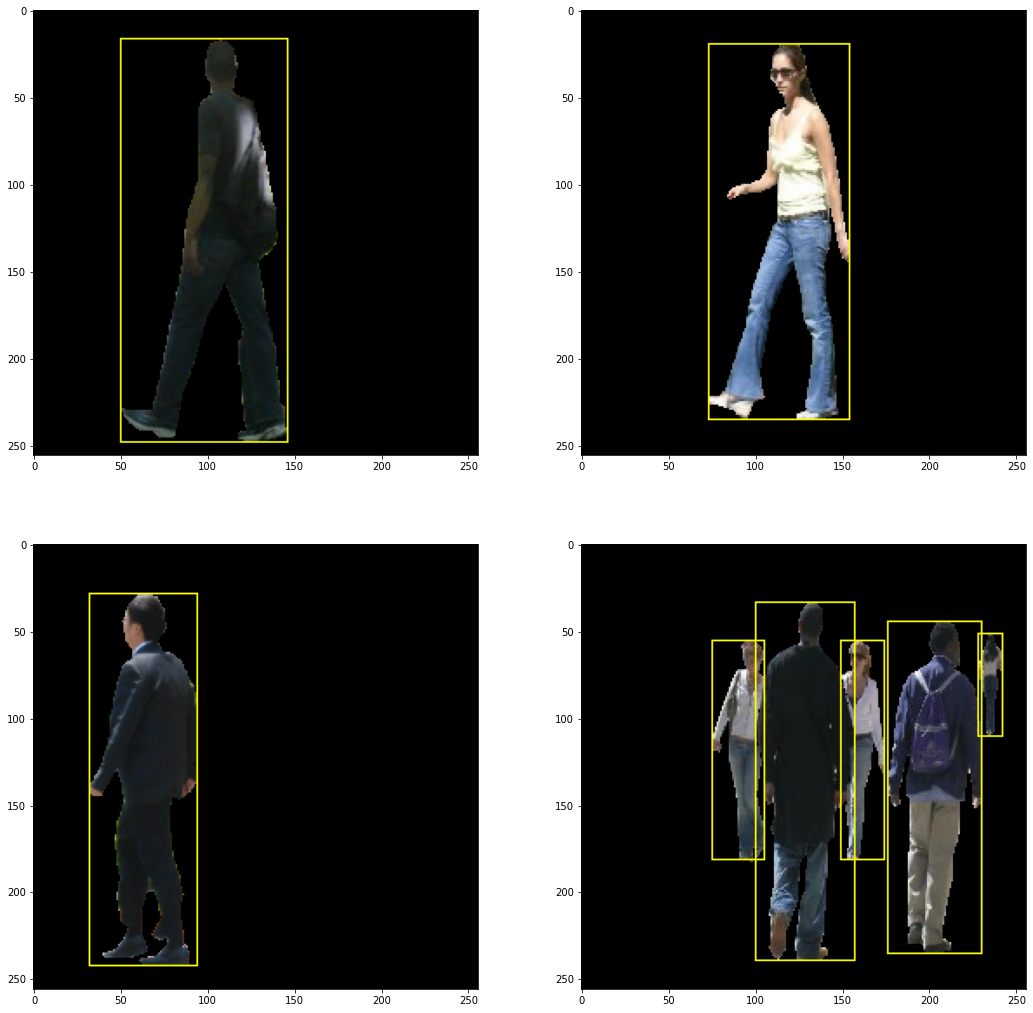

In [ ]:
train_iter = iter(dataloader_tr)
x, target = next(train_iter)
boxes = [i["boxes"] for i in target]
masks = [i["masks"] for i in target]

vis(x, boxes, masks, imgs_per_row=2)

In [ ]:
def minmax_to_centroid(coords_tensor, normalize_size=1):
    """
    Transforms coordinates from minmax representation to centroid.
    Can normalize representation relatively to image size.
    """
    center_coords_list = []
    for coords in coords_tensor:
        min_x, min_y, max_x, max_y = coords
        w, h = abs(max_x - min_x), abs(max_y - min_y) # for good measure
        cx, cy = min_x + w/2, min_y + h/2 
        center_coords_list.append([cx, cy, w, h])
    return torch.tensor(center_coords_list) / normalize_size

def centroid_to_minmax(coords_tensor):
    """Transforms coordinates from centroid representation to minmax."""
    minmax_coords_list = []
    for coords in coords_tensor:
        cx, cy, w, h = coords
        min_x, min_y = cx - w/2, cy  - h/2
        max_x, max_y = cx + w/2, cy + h/2
        minmax_coords_list.append([min_x, min_y, max_x, max_y])
    return torch.tensor(minmax_coords_list)

def get_default_box(scale, aspect_ratio, f_x, f_y, f_size):
    """Generates default box in centroid representation."""
    w, h = scale * np.sqrt(aspect_ratio), scale / np.sqrt(aspect_ratio)
    cx, cy = (f_x + 0.5) / f_size, (f_y + 0.5) / f_size
    return torch.tensor([cx, cy, w, h]).float()

def get_default_box_offset_from_truth(ground_truth_box, default_box):
    """Generates offset for default box to be equvalent to ground truth box."""
    cx_true, cy_true, w_true, h_true = ground_truth_box
    cx_default, cy_default, w_default, h_default = default_box

    cx_offset, cy_offsest = (cx_true - cx_default)/w_default, (cy_true - cy_default)/h_default
    w_offset, h_offset = np.log(w_true/w_default), np.log(h_true/h_default)
    return torch.tensor([cx_offset, cy_offsest, w_offset, h_offset]).float()

In [ ]:
def denormalize_offset(offset, default_box_width, default_box_height):
    """Decodes offset so that it could be used to apply offset default box."""
    cx_offset, cy_offset, w_offset, h_offset = offset
    return torch.tensor([cx_offset*default_box_width, cy_offset*default_box_height, np.exp(w_offset), np.exp(h_offset)])

def true_offset_default_box(default_box, offset, img_size):
    """Applies offset so that default box is equvalent to ground truth box."""
    cx_default, cy_default, w_default, h_default = default_box
    cx_delta, cy_delta, w_delta, h_delta = denormalize_offset(offset, w_default, h_default)

    cx, cy = (cx_default + cx_delta) * img_size, (cy_default + cy_delta) * img_size
    w, h = w_default * w_delta * img_size, h_default * h_delta * img_size
    return torch.tensor([cx, cy, w, h])

In [ ]:
# img_index = 0

# coords = boxes[img_index]
# center = minmax_to_centroid(coords, 256)[0]

# default_box = get_default_box(0.4, 0.4, 15, 10, 20)
# offset = get_default_box_offset_from_truth(center, default_box)

# corrected_default_box = true_offset_default_box(default_box, offset, 256)

# print(center)
# print(default_box)
# print(offset)
# print(corrected_default_box)

# """VIS"""

# img = x[img_index]
# vis(img, coords)
# vis(img, centroid_to_minmax(default_box.unsqueeze(0) * 256))
# vis(img, centroid_to_minmax(corrected_default_box.unsqueeze(0)))

In [ ]:
def get_box_categ_indecies(default_box_amount, categoires_amount):
    """Returns indecies for default box offset params and categories predictions for each default box."""
    coord_indecies = []
    categ_indecies = []

    default_box_par_amount = 4+categoires_amount
    par_amount = default_box_amount*(default_box_par_amount)
    
    for i in range(default_box_par_amount, par_amount+default_box_par_amount, default_box_par_amount):
        start = i-default_box_par_amount
        coord_indecies.append(list(range(start, start+4)))
        categ_indecies.append(list(range(start+4, i)))

    return torch.tensor(coord_indecies), torch.tensor(categ_indecies)

def get_scales(layers_amount, s_min=0.2, s_max=0.9):
    def scale_for_layer(k):
        return s_min + ((s_max-s_min)/(layers_amount-1)) * (k-1)
    scale = [scale_for_layer(k) for k in range(1, layers_amount)]
    scale.append(s_max)
    return scale

In [ ]:
from itertools import product


class DefaultBoxGenerator:
    def __init__(self, cfg):
        self.feature_map_sizes = cfg["feature_map_sizes"]
        self.default_box_amounts = cfg["default_box_amounts"]
        self.scales = cfg["scales"]
        self.ascpet_ratios = cfg["aspect_ratios"]

    def forward_nonlinear(self):
        """
        Returns list of tensors where each tensor corresponds to each feature map.
        Each tensors shape (C, H, W)
        C = default_box_amount * 4
        so default boxes corresponding to the same cell are squeezed toghether.
        """
        boxes = []
        for k, feature_map in enumerate(self.feature_map_sizes):
            boxes_by_layer = []
            scale = self.scales[k]
            for y, x in product(range(feature_map), repeat=2):
                cell_boxes = []
                for i in range(self.default_box_amounts[k]):
                    aspect_ratio = self.ascpet_ratios[i]
                    used_scale = scale
                    if aspect_ratio == 1:
                        if k != len(self.feature_map_sizes) - 1:
                            used_scale = np.sqrt(scale * self.scales[k+1])
                        else: # when k is the last layer
                            used_scale = np.sqrt(self.scales[k-1] * scale)
                    cell_boxes.append(get_default_box(used_scale, aspect_ratio, x, y, feature_map))
                boxes_by_layer.append(torch.stack(cell_boxes, 0).view(-1, 1))
            boxes.append(torch.stack(boxes_by_layer, 1).view(-1, feature_map, feature_map))
        return boxes

    def forward_linear(self):
        boxes = []
        for k, feature_map in enumerate(self.feature_map_sizes):
            scale = self.scales[k]
            for y, x in product(range(feature_map), repeat=2):
                for i in range(self.default_box_amounts[k]):
                    aspect_ratio = self.ascpet_ratios[i]
                    used_scale = scale
                    if aspect_ratio == 1:
                        if k != len(self.feature_map_sizes) - 1:
                            used_scale = np.sqrt(scale * self.scales[k+1])
                        else: # when k is the last layer
                            used_scale = np.sqrt(self.scales[k-1] * scale)
                    boxes.append(get_default_box(used_scale, aspect_ratio, x, y, feature_map))
        return torch.stack(boxes)


def linearize_layer_boxes(boxes):
    """
    input: (4*N, W, H)
    output: (N*W*H, 4) tensor of all the boxes
    """
    # channel length
    c = boxes.shape[0]
    #boxes per channel
    bpc = boxes.shape[0]//4
    return boxes.view(c, -1).T.view(-1, bpc, 4).reshape(-1, 4)

def decoder_linear(boxes, cfg):
    fmp = cfg["feature_map_sizes"]
    dba = cfg["default_box_amounts"]
    boxes_by_layer = []
    global_block_end = 0
    for i, f_size in enumerate(fmp):
        boxes_by_aspect = []
        block_end = global_block_end + f_size**2 * dba[i]
        for k in range(dba[i]):
            boxes_by_aspect.append(boxes[global_block_end+k:block_end:dba[i]])
            if k == dba[i]-1:
                global_block_end = block_end
        boxes_by_layer.append(torch.stack(boxes_by_aspect, 0))
    return boxes_by_layer

In [ ]:
cfg = {"feature_map_sizes": [40, 30, 20, 10, 5],
       "default_box_amounts": [5, 5, 5, 5, 5],
       "class_amount": 2,
       "scales": get_scales(5), 
       "aspect_ratios": [1/3, 1/2, 1, 1.5, 2]}

g = DefaultBoxGenerator(cfg)
boxes = g.forward_linear()

In [ ]:
print(boxes.shape)

torch.Size([15125, 4])


In [ ]:
lb = decoder_linear(boxes, cfg)

In [ ]:
sec = lb
print([i.shape for i in sec])

[torch.Size([5, 1600, 4]), torch.Size([5, 900, 4]), torch.Size([5, 400, 4]), torch.Size([5, 100, 4]), torch.Size([5, 25, 4])]


In [ ]:
# display_boxes = centroid_to_minmax(sec[4][0])
# vis(x[0], display_boxes*256)

In [ ]:
def linearize_layer_conv(head_out, param_amount):
    feature_map_size = head_out.shape[1]
    return head_out.reshape(-1, feature_map_size**2).T.view(-1, param_amount)

def linearize_layer_conv(head_out, param_amount):
    feature_map_size = head_out.shape[-1]
    if len(head_out.shape) > 3:
        batch_dim = head_out.shape[0]
        return head_out.reshape(batch_dim, -1, feature_map_size**2).permute(0, 2, 1).reshape(batch_dim, -1, param_amount)
    return head_out.reshape(-1, feature_map_size**2).T.view(-1, param_amount)

In [ ]:
cfg = {'default_box_amounts': [4, 2, 1], 
       'class_amount': 2, 
       'aspect_ratios': [0.3333333333333333, 0.5, 1, 1.5, 2], 
       'img_size': 256, 
       'feature_map_sizes': [2, 3, 4], 
       'scales': [0.2, 0.55, 0.9]}


def gen_data(f_size, db_amount, par_amount):
    ini = torch.arange(db_amount*par_amount*(f_size**2))
    return ini.view(f_size**2, db_amount*par_amount).T.reshape(db_amount*par_amount, f_size, f_size)



a1 = gen_data(cfg["feature_map_sizes"][0], cfg["default_box_amounts"][0], 4)
a2 = gen_data(cfg["feature_map_sizes"][1], cfg["default_box_amounts"][1], 4)
a3 = gen_data(cfg["feature_map_sizes"][2], cfg["default_box_amounts"][2], 4)

a = [a1, a2, a3]

b1 = nn.Flatten(start_dim=1, end_dim=-1)(a1)
b2 = nn.Flatten(start_dim=1, end_dim=-1)(a2)
b3 = nn.Flatten(start_dim=1, end_dim=-1)(a3)

b = [b1, b2, b3]

c = torch.cat([linearize_layer_conv(i, 4) for i in a])

In [ ]:
print(a3)
print(30*"#")
print(b3)

tensor([[[ 0,  4,  8, 12],
         [16, 20, 24, 28],
         [32, 36, 40, 44],
         [48, 52, 56, 60]],

        [[ 1,  5,  9, 13],
         [17, 21, 25, 29],
         [33, 37, 41, 45],
         [49, 53, 57, 61]],

        [[ 2,  6, 10, 14],
         [18, 22, 26, 30],
         [34, 38, 42, 46],
         [50, 54, 58, 62]],

        [[ 3,  7, 11, 15],
         [19, 23, 27, 31],
         [35, 39, 43, 47],
         [51, 55, 59, 63]]])
##############################
tensor([[ 0,  4,  8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60],
        [ 1,  5,  9, 13, 17, 21, 25, 29, 33, 37, 41, 45, 49, 53, 57, 61],
        [ 2,  6, 10, 14, 18, 22, 26, 30, 34, 38, 42, 46, 50, 54, 58, 62],
        [ 3,  7, 11, 15, 19, 23, 27, 31, 35, 39, 43, 47, 51, 55, 59, 63]])


In [ ]:
print(c)

tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15],
        [16, 17, 18, 19],
        [20, 21, 22, 23],
        [24, 25, 26, 27],
        [28, 29, 30, 31],
        [32, 33, 34, 35],
        [36, 37, 38, 39],
        [40, 41, 42, 43],
        [44, 45, 46, 47],
        [48, 49, 50, 51],
        [52, 53, 54, 55],
        [56, 57, 58, 59],
        [60, 61, 62, 63],
        [ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15],
        [16, 17, 18, 19],
        [20, 21, 22, 23],
        [24, 25, 26, 27],
        [28, 29, 30, 31],
        [32, 33, 34, 35],
        [36, 37, 38, 39],
        [40, 41, 42, 43],
        [44, 45, 46, 47],
        [48, 49, 50, 51],
        [52, 53, 54, 55],
        [56, 57, 58, 59],
        [60, 61, 62, 63],
        [64, 65, 66, 67],
        [68, 69, 70, 71],
        [ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15],
        [16,

In [ ]:
print(b1.shape)
print(b2.shape)
print(b3.shape)
print(c.shape)

torch.Size([16, 4])
torch.Size([8, 9])
torch.Size([4, 16])
torch.Size([50, 4])


In [ ]:
print(cfg)

{'default_box_amounts': [4, 2, 1], 'class_amount': 2, 'aspect_ratios': [0.3333333333333333, 0.5, 1, 1.5, 2], 'img_size': 256, 'feature_map_sizes': [2, 3, 4], 'scales': [0.2, 0.55, 0.9]}


In [ ]:
"""
ilość default boxów: 3
ilość parametrów: 2
szerokość feature mapy: 4

cel:

id 1d ----> id 2d
3*2*(4**2) | 3*2 X 4**2

I. po feature mapach
II. po koordynatach czyli po wierszach macierzy
III. po default boxach

kolejne komórki będą co 3*2
mamy wiedze ile wynosi szerokość i wyskość danej feature mapy

"""

def linear_id_to_cubic(id, cfg, parameters_amount):
    decoded_id = id * parameters_amount
    move_id = 0
    for i, feature_map_size in enumerate(cfg["feature_map_sizes"]):
        default_box_amount = cfg["default_box_amounts"][i]
        curr_layer_para_amount = feature_map_size**2 * default_box_amount * parameters_amount
        if curr_layer_para_amount + move_id <= decoded_id:
            move_id += curr_layer_para_amount
        else:
            break
    decoded_id -= move_id

    column_size = default_box_amount * parameters_amount

    col_id = decoded_id // column_size
    row_id = decoded_id % column_size

    return i, col_id, [row_id + i for i in range(parameters_amount)]

id = 49 # te id też są co ilość parametrów

i, col_id, row_ids = linear_id_to_cubic(id, cfg, 4)

print(i, col_id, row_ids)
print()

print("linear", c[id])
print("cubic", b[i][row_ids, col_id])

# print("test")

# for _ in range(14820):
#     i, col_id, row_ids = linear_id_to_cubic(id, cfg, 4)

#     v1 = c[id]
#     v2 = b[i][row_ids, col_id]
#     boo = torch.equal(v1, v2)
#     if not boo:
#         print(v1)
#         print(v2)

2 15 [0, 1, 2, 3]

linear tensor([60, 61, 62, 63])
cubic tensor([60, 61, 62, 63])


In [ ]:
def match_boxes(default_boxes, ground_truth_boxes):
    scores = OPS.box_iou(default_boxes, ground_truth_boxes)
    return torch.nonzero(scores >= 0.5)

In [ ]:
print(boxes.shape)
print(centroid_to_minmax(boxes).shape)

torch.Size([15125, 4])
torch.Size([15125, 4])


In [ ]:
test_img = x[0]
test_default_boxes = centroid_to_minmax(boxes) * 256
test_ground_truth_boxes = target[0]["boxes"]

match = match_boxes(test_default_boxes, test_ground_truth_boxes)

In [ ]:
default_boxes_indecies, ground_truth_indecies = match[:, 0], match[:, 1]

In [ ]:
matched_default_boxes = torch.index_select(test_default_boxes, 0, default_boxes_indecies)
matched_ground_truth_boxes = torch.index_select(test_ground_truth_boxes, 0, ground_truth_indecies)

In [ ]:
# vis(test_img, matched_default_boxes)

In [ ]:
# vis(test_img, matched_ground_truth_boxes)

In [ ]:
def loc_loss(predicted_offset, ground_truth_offset):
    """Calculates loc_loss with smooth l1 for postive default_boxes."""
    return nn.SmoothL1Loss()(predicted_offset, ground_truth_offset)

def conf_loss(predicted_categories, true_categories):
    """Calculates conf_loss with cross entropy for all default boxes, output is not averaged."""
    return nn.CrossEntropyLoss(reduction="none")(predicted_categories, true_categories)

In [ ]:
class ConvModule(nn.Module):
    def __init__(self, in_channels, num_features):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, num_features, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(num_features),
            nn.ReLU()
        )

    def forward(self, x):
        return self.layers(x)


class HeadModule(nn.Module):
    def __init__(self, in_channels, default_box_amount, class_amount):
        super().__init__()
        self.conv_loc = nn.Sequential(
            nn.Conv2d(in_channels, default_box_amount*4, 3),
            nn.ReLU(),
            nn.Flatten(2))
        
        self.conv_conf = nn.Sequential(
            nn.Conv2d(in_channels, default_box_amount*class_amount, 3),
            nn.ReLU(),
            nn.Flatten(2))

    def forward(self, x):
        return self.conv_loc(x), self.conv_conf(x)


class SimpleSSD(nn.Module):
    def __init__(self, init_Ch, cfg, max_num_features=128):
        super().__init__()
        mnf = max_num_features

        default_box_amounts = iter(cfg["default_box_amounts"])
        class_amount = cfg["class_amount"]

        self.conv0 = ConvModule(init_Ch, mnf//4) # 128
        self.conv1 =  ConvModule(mnf//4, mnf//4) # 64
        self.conv2 = ConvModule(mnf//4, mnf//2) # 32
        self.conv3 = ConvModule(mnf//2, mnf) # 16
        
        self.head1 = HeadModule(mnf//4, next(default_box_amounts), class_amount)
        self.head2 = HeadModule(mnf//2, next(default_box_amounts), class_amount)
        self.head3 = HeadModule(mnf, next(default_box_amounts), class_amount)

    def forward(self, x):
        x0 = self.conv0(x)
        x1 = self.conv1(x0)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)

        h1_loc, h1_conf = self.head1(x1)
        h2_loc, h2_conf = self.head2(x2)
        h3_loc, h3_conf = self.head3(x3)

        return [h1_loc, h2_loc, h3_loc], [h1_conf, h2_conf, h3_conf]

In [ ]:
cfg = {"default_box_amounts": [3, 3, 3],
       "class_amount": 2, 
       "aspect_ratios": [1/3, 1/2, 1, 1.5, 2],
       "img_size": 256}

epochs = 20
ssd_net = SimpleSSD(3, cfg)
opt = optim.Adam(ssd_net.parameters(), lr=0.005)

head_shapes = []

for epoch in range(epochs):
    for i, batch in enumerate(dataloader_tr):
        imgs, targets = batch
        locs, confs = ssd_net(imgs)
        if epoch == 0 and i == 0: # first iteration and first batch
            for loc in locs: # capture shapes of head feature maps
                head_shapes.append(int(np.sqrt(loc.shape[2])))

            cfg["feature_map_sizes"] = head_shapes
            cfg["scales"] = get_scales(len(head_shapes))
            print(cfg)
            g = DefaultBoxGenerator(cfg) # generate default boxes
            default_boxes = g.forward_linear()
            minmax_default_boxes = centroid_to_minmax(default_boxes) * cfg["img_size"]

        batch_ground_truth_boxes = [i["boxes"] for i in targets]
        labels = [i["labels"] for i in targets]

        batch_matches = []

        for ground_truth_boxes in batch_ground_truth_boxes:
            batch_matches.append(match_boxes(minmax_default_boxes, ground_truth_boxes))

        l_loc_losses = []
        l_conf_losses = []
        for batch_id, matches in enumerate(batch_matches):
            loc_layers = [j[batch_id] for j in locs]
            centroid_ground_truth_boxes = minmax_to_centroid(batch_ground_truth_boxes[batch_id])
            l_loc_loss = 0
            l_conf_loss = 0

            pos_ids = set()

            for el in matches:
                default_box_id, ground_truth_box_id = el
                
                l_f_id, l_col_id, l_row_ids = linear_id_to_cubic(int(default_box_id), cfg, 4)
                predicted_default_box_offsets = loc_layers[l_f_id][l_row_ids, l_col_id]

                c_f_id, c_col_id, c_row_ids = linear_id_to_cubic(int(default_box_id), cfg, 2)
                predicted_default_box_classes = loc_layers[c_f_id][c_row_ids, c_col_id]

                default_box = default_boxes[default_box_id]
                ground_truth_box = centroid_ground_truth_boxes[ground_truth_box_id]

                ground_truth_offset = get_default_box_offset_from_truth(ground_truth_box, default_box)
                l_loc_loss += loc_loss(predicted_default_box_offsets, ground_truth_offset)

                l_conf_loss += conf_loss(predicted_default_box_classes.view(-1, 2), torch.tensor([[0., 1.]]))
                pos_ids.add(default_box_id)

            l_loc_losses.append(l_loc_loss)

            for default_box_id in range(len(matches)):
                if default_box_id not in pos_ids:
                    c_f_id, c_col_id, c_row_ids = linear_id_to_cubic(int(default_box_id), cfg, 2)
                    predicted_default_box_classes = loc_layers[c_f_id][c_row_ids, c_col_id]
                    l_conf_loss += conf_loss(predicted_default_box_classes.view(-1, 2), torch.tensor([[1., 0.]]))
            
            l_conf_losses.append(l_conf_loss)
        
        l_loc_losses = torch.stack(l_loc_losses).view(-1, 4)
        l_conf_losses = torch.stack(l_conf_losses).view(-1, 4)
        print(l_loc_losses)
        print(l_conf_losses)
        break
    break

{'default_box_amounts': [3, 3, 3], 'class_amount': 2, 'aspect_ratios': [0.3333333333333333, 0.5, 1, 1.5, 2], 'img_size': 256, 'feature_map_sizes': [62, 30, 14], 'scales': [0.2, 0.55, 0.9]}
tensor([[16390.0273, 32899.6953, 17839.2188, 38851.0781]],
       grad_fn=<ViewBackward0>)
tensor([[ 94.0979, 330.2361, 251.0249, 137.7390]], grad_fn=<ViewBackward0>)
